In [1]:
import scipy.io
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from os import chdir
chdir('data/Cp_16_05_01')

In [82]:
import time as tm
def timing(f):
    def wrap(*args, **kwargs):
        time1 = tm.time()
        ret = f(*args, **kwargs)
        time2 = tm.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

## Préparation et visualisation des données

### Bases de données GPS et vitesse

In [3]:
#Telechargement des données pour l'experience 1 (qui sont sous forme de dictionnaire)
exp_ind = 1
gps1 = scipy.io.loadmat('juan{}_gps.mat'.format(exp_ind))
sensors1 = scipy.io.loadmat('juan{}_etc.mat'.format(exp_ind))

In [4]:
#Mise en forme en Data Frame
gps_df = pd.DataFrame(gps1['GPS'], columns=gps1['GPSFieldsOrder'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns=sensors1['ETCFieldsOrder'])

In [5]:
#Changement du nom des variables
gps_df = pd.DataFrame(gps1['GPS'], columns = ['time', 'ts', 'lat', 'long', 'alti', 'course', 'speedOG', 'speedV', 
                                              'SgmLat', 'SgmLong', 'SgmAlti', 'mode', 'sats'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns = ['time', 'counts', 'accel', 'steer', 'brake', 'speed'])

In [6]:
#Bien mettre en forme les données 

def readSensorData(sensors_df):
    '''Velocity and steering'''
    # Sensor params
    KV1 = 0.024970 * (1 - 0.21)
    KA1 = 0.00040 * (1 + 0)
    KA0 = 2022
    Kx1 = 1.0127
    Kx2 = 0.0042
    
    time_sensors = sensors_df['time'].values / 1000.
    steering = Kx1 * (sensors_df['steer'].values - KA0) * KA1 + Kx2 
    velocity = KV1 * sensors_df['speed'].values
    
    return time_sensors, steering, velocity


def readGPSData(gps_df):
    '''Latitude and longtitude'''
    # Reference point
    LAT0  = -33.8884
    LONG0 = 151.1948
    
    # Params (wtf is this sorcery)
    a =  6378137.0
    b  = a * (1 - 0.003352810664747)
    kpi = np.pi / 180
    cf = np.cos(LAT0 * kpi)
    sf = np.abs(np.sin(LAT0 * kpi))
    Ro = a ** 2 * cf / np.abs(np.sqrt((a *cf) ** 2 + (b * sf) ** 2))  ;
    RR = b / a  * np.abs(np.sqrt(a ** 2- Ro ** 2)) / sf ;
    
    time_gps = gps_df['time'].values / 1000.
    latitude = - RR * kpi * (gps_df['lat'].values + LAT0)
    longtitude = Ro * kpi * (gps_df['long'].values - LONG0)
    
    return time_gps, latitude, longtitude

In [7]:
def scanData():
    '''
    Pour avoir le temps, le sensor et l'indice de chaque mesure qui arrive
    Au temps time[i] on a une mesure de sensor[i]
    (1 si gps, 2 si steering et velocity)
    dans l'indice index[i] du tableau correspondant
    '''
    time_sensors, steering, velocity = readSensorData(sensors_df)
    time_gps, latitude, longtitude = readGPSData(gps_df)
    
    times = [(1, i, time) for i, time in enumerate(time_gps)]
    times.extend([(2, i, time) for i, time in enumerate(time_sensors)])

    times = np.array(sorted(times, key=lambda u: u[2]))
    time, sensor, index = times[:, 2], times[:, 0], times[:, 1].astype(int)
    return time, sensor, index

In [8]:
#Construction des bases de données finales 
GPSData = pd.DataFrame(readGPSData(gps_df), ['times_GPS', 'latitude', 'longitude']).T
SensorData = pd.DataFrame(readSensorData(sensors_df), ['time_sensors', 'steering', 'velocity']).T

In [9]:
GPSData.head()

,times_GPS,latitude,longitude
0,851.227,-5.707890,6.615680
1,851.428,-5.709734,6.615680
2,851.628,-5.702355,6.614138
3,851.828,-5.700510,6.615680
4,852.028,-5.702355,6.615680


In [10]:
SensorData.head()

,time_sensors,steering,velocity
0,851.292,0.064557,0.0
1,851.317,0.064962,0.0
2,851.342,0.064557,0.0
3,851.367,0.064557,0.0
4,851.392,0.064557,0.0


## Petites visualisations

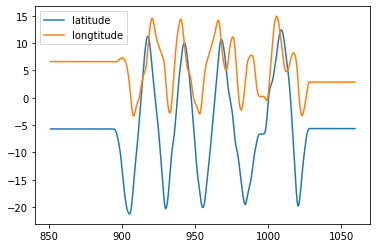

In [11]:
time_gps, latitude, longtitude = readGPSData(gps_df)
plt.plot(time_gps, latitude, label='latitude')
plt.plot(time_gps, longtitude, label='longtitude')
plt.legend()

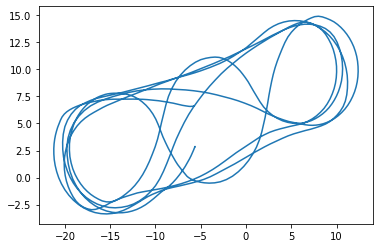

In [12]:
plt.plot(latitude, longtitude)

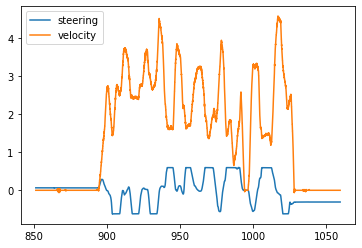

In [13]:
time_sensors, steering, velocity = readSensorData(sensors_df)
plt.plot(time_sensors, steering, label='steering')
plt.plot(time_sensors, velocity, label='velocity')
plt.legend()

### Quelques probas / generateurs aleatoires utiles:

In [16]:
from scipy.stats import dirichlet, multivariate_normal, beta, norm

In [17]:
# Parametres pour le modele de transition (partie bruit)
timestep = (time_sensors[-1] - time_sensors[0]) / (len(time_sensors) - 1)
noise_measures = np.zeros((len(time_sensors) - 2, 2))
# Derivee de la vitesse
noise_measures[:, 0] = (velocity[1:-1] - velocity[:-2]) / timestep
# Derivee seconde de beta
noise_measures[:, 1] = (steering[2:] - 2 * steering[1:-1] + steering[:-2]) / (timestep ** 2)

#Covariance comme esperance
noise_cov = noise_measures.T @ noise_measures / (len(time_sensors) - 2)
noise_mean = np.zeros(2)

Petites sous-fonctions de l'algo final à compléter :

In [18]:
def q_alpha(alpha_1_prev, c_t, sigma_t) :
    '''
    === ÉQUATION 26 page 11 ===
    Ici, alpha1 est dans {0, 1}. Par l'article, la loi de Dirichlet est réduite
    à une loi beta.
    '''
#     alpha_prime_prev = np.empty(2)
#     alpha_prime_prev[0] = (sigma_t * alpha_1_prev[0] + (c == 0)) / (sigma_t + 1)
#     alpha_prime_prev[1] = (sigma_t * alpha_1_prev[1] + (c == 1)) / (sigma_t + 1)
    
#     rv = dirichlet((1 + sigma_t) * alpha_prime_prev)

    rv = beta(sigma_t * alpha_1_prev + (c == 0))
    
    sampled = rv.rvs()
    proba = rv.pdf(sampled)
    
    
    
    return sampled, proba

In [19]:
var_gps = 1
var_sensors = {'beta': 0.2, 'v': 0.1}

p0_z1 = lambda u: 1e-3 # Uniforme sur un grand intervalle
# Etat de "mauvais" fonctionnement du gps

h1 = lambda state: [state['x'], state['y']]

S = var_gps * np.diag(2 * np.ones(2)) # + ?
# Je dirais = 0 parce que le gradient est nul
# puisque x et y ne dependent du noise qu'au 2nd ordre

def q_c1(x_pred, S1, alpha1, z1) :
    '''
    === ÉQUATION 29 page 11 === 
    '''
    # Probabilite que c_{1, t} = 0:
    p_c_0 = alpha1 *  p0_z1(z1) / (alpha1 *  p0_z1(z1) + (1 - alpha) * multivariate_normal.pdf(z1, h1(x_pred), S1))
    sampled = np.random.binomial(1, p_c_0)
    return sampled, p_c_0 if sampled == 0 else 1 - p_c_0


In [20]:
# Attention a ca, la densite indiquee dans l'article est bizarre
def q_sigma1 (s1, sigma1_new, sigma1, alpha1_new, alpha1) :
    '''
    === ÉQUATION 28 page 11 ===
    La formule est donnée avec un log.
    Pas de s1 = sigma_{1, t}^alpha ? 
    '''
    lambda_a = 1 * np.random.randn(1) # définir la variance de lambda^alpha, c'est un bruit blanc gaussien
    numerateur = np.random.dirichlet(sigma1_new * alpha1) * (lambda_a * np.random.randn(1) + np.log(sigma1))
    denominateur = np.random.dirichlet(sigma1 * alpha1)
    return numerateur / denominateur

# Algorithme pf classique

In [28]:
def initilisation_pf(N): #on initialise avec des uniformes sur les espaces de vie des variables
    stretch = 1.02
    
    x_min, x_max = np.min(stretch * latitude), np.max(stretch * latitude)
    y_min, y_max = np.min(stretch * longtitude), np.max(stretch * longtitude)
    v_max = np.max(stretch * velocity)
    beta_min, beta_max = np.min(stretch * steering), np.max(stretch * steering)
    beta_dot = (steering[1:] - steering[:-1]) / (time_sensors[1:] - time_sensors[:-1])
    beta_dot_min, beta_dot_max = np.min(stretch * beta_dot), np.max(beta_dot)
    
    init_state = {
        'x': np.random.uniform(low= -8, high=-4, size=N),
        'y': np.random.uniform(low=3, high=8, size=N),
        'v': np.random.uniform(low=0, high=v_max, size=N),
        'psi': np.random.uniform(low=0, high=2*np.pi, size=N),
        'beta': np.random.uniform(low=beta_min, high=beta_max, size=N),
        'beta_dot': np.random.uniform(low=beta_dot_min, high=beta_dot_max, size=N)
    }
    init_sensor_state = {
        'sigma': np.exp(np.random.normal(0, 1, size=N)), 
        'alpha': np.exp(np.random.normal(0, 1, size=N)),
    }
    init_poids = np.ones(N) / N
    
    return init_state, init_sensor_state, init_poids 



# Geometric constants
L = 2.83
H = 0.76
a = 3.78
b = 0.5

def transition_model(current_state, dt, with_noise=True):
    '''return the state transition model taking into
    account he state noise (v' and beta'')'''
    # Retrieve initial states
    x = current_state['x']
    y = current_state['y']
    v = current_state['v']

    psi = current_state['psi']
    beta = current_state['beta']
    beta_dot = current_state['beta_dot']
    
    # Next states
    next_state = dict()
    next_state['x'] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state['y'] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state['v'] = v
    
    next_state['psi'] = psi + dt * v * np.tan(beta) / L
    next_state['beta'] = beta + dt * beta_dot
    next_state['beta_dot'] = beta_dot
    
    if with_noise:
        state_noise = np.random.multivariate_normal(noise_mean, noise_cov, size=x.shape[0])
        next_state['v'] += dt * state_noise[:, 0]
        next_state['beta_dot'] += dt * state_noise[:, 1]

    return next_state



def update_model(N, weights, update_GPS, measures, particles):    
    #Cas GPS
    if update_GPS:
        erreur_mesure_x = particles['x'] - measures['x'] 
        erreur_mesure_y = particles['y'] - measures['y']
        
        weights *= norm(0, 0.002).pdf(erreur_mesure_x)
        weights *= norm(0, 0.002).pdf(erreur_mesure_y)
        
#         for i in range(N): #mise à jour des poids
#             weights[i] *= norm(0, 0.2).pdf(erreur_mesure_x[i])
#             weights[i] *= norm(0, 0.2).pdf(erreur_mesure_y[i])
#             weights[i] *= norm(0, 0.002).pdf(erreur_mesure_x[i])
#             weights[i] *= norm(0, 0.002).pdf(erreur_mesure_y[i])

    #Cas sensors   
    else:
#         erreur_mesure_beta = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
#         erreur_mesure_v = particles['v'] - measures['v']
        # h3(x_t) = beta_t
        erreur_mesure_h3 = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        # h2(x_t) = (1 + tan(beta_t)) * v_t
        erreur_mesure_h2 = (1 + np.tan(particles['beta']) * H / L) * particles['v'] - (1 + np.tan(measures['beta']) * H / L) * measures['v']
        weights *= (
                norm(0, 0.1).pdf(erreur_mesure_h2)
                * norm(0, 0.002).pdf(erreur_mesure_h3)
            )
#         for i in range(N): #mise à jour des poids
#             weights[i] *= 1
#             weights[i] *= norm(0, 0.1).pdf(erreur_mesure_v[i])
#             weights[i] *= norm(0, 0.002).pdf(erreur_mesure_beta[i])
#             weights[i] *= (
#                 norm(0, 0.1).pdf(erreur_mesure_h2[i])
#                 * norm(0, 0.002).pdf(erreur_mesure_h3[i])
#             )
    weights += 1e-300 # Eviter les divisions par 0
    weights /= sum(weights) # normalize
    
        
    return weights





def simple_resample(N, particles, weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, size=N))
    # resample according to indexes
    particles = {key: particles[key][indexes] for key in particles}
    weights.fill(1.0 / N)
    return particles, weights





def resample_v2(N, particles, weights):
    
    weights_index_sort = np.argsort(weights)
    index_particles_alive = weights_index_sort[int(0.7*N) :] #cut the tab
    len_tab_cut = len(index_particles_alive)
    
    
    for ii in range(N - len_tab_cut):
        index_particles_alive = np.append(index_particles_alive, 
                                          index_particles_alive[np.random.randint(0, len_tab_cut)])
        
    
    new_particles = particles = {key: particles[key][index_particles_alive] for key in particles}
    weights.fill(1.0 / N)
        
    return new_particles, weights

def resample_v3(N, particles, weights):
    index_particles_alive = np.random.choice(N, size=N, p=weights)
    new_particles = {key: particles[key][index_particles_alive] for key in particles}
    return new_particles, np.ones(N) / N




def predictions(weights, particles): #Renvoi la prédiction de l'état à chaque temps
    tab_predict = [sum(particles['x'] * weights), sum(particles['y'] * weights), sum(particles['v'] * weights), 
     sum(particles['beta'] * weights)]
    
    return tab_predict

In [83]:
#Définissons maintenant le corps de l'algo avec les différentes fonctions crées

@timing
def particle_filter(N, time):
    
    #Liste à remplir
    list_predict = list()
    list_particles = list()
    list_mesures = list()
    list_erreur = list()

    
    #Initialisation de l'algo
    particles, _, weights = initilisation_pf(N)
    t_previous = time[0]
    
    for i in range(len(time)):
        
        t = time[i] 
        particles = transition_model(particles, dt=(t-t_previous)/1000)
        
        update_GPS = sensor[i] == 1 # True si la i-eme mesure est celle du GPS   
        
        if update_GPS:
            #print('mesure GPS')
            measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
            list_mesures.append([measures,i])
                
        else :
            measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}

        weights = update_model(N, weights, update_GPS, measures, particles)
    
        
        
            
        # Resampling
        n_eff = 1 / np.sum(weights ** 2)
        
        #if update_GPS:
            #print(n_eff)
            
        if n_eff <= .8 * N:
            particles, weights = resample_v3(N, particles, weights)
            
        t_previous = t
        list_predict.append(predictions(weights, particles))
        
        if update_GPS:
            list_erreur.append(abs(predictions(weights, particles)[0] - latitude[index[i]]) + 
                              abs(predictions(weights, particles)[1] - longtitude[index[i]]))
        
        list_particles.append(particles)
            
    return list_predict, list_particles, list_mesures, list_erreur



# Application  avec notre filtre particulaire

In [84]:
#Le vecteur temps
time_sensors, steering, velocity = readSensorData(sensors_df)
time_gps, latitude, longtitude = readGPSData(gps_df)
time, sensor, index = scanData()

Pour 100 unités de temps nous avons : 112 mesures GPS


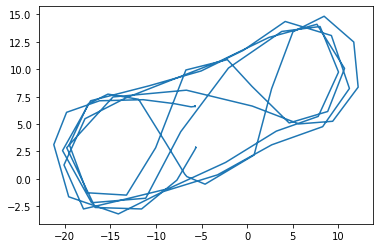

In [85]:
#Concentrons nous sur une période de temps plus courte

time_short = time[:1000]
list_longi = list()
list_lati = list()

for i in range(len(time_short)):
        update_GPS = sensor[i] == 1
        if update_GPS:
            list_lati.append(latitude[i])
            list_longi.append(longtitude[i])

print('Pour 100 unités de temps nous avons :', len(list_lati), 'mesures GPS')            
plt.plot(list_lati, list_longi)


In [47]:
#On lance la fonction par sur 100 premières unités de temps
list_predict, list_particles, list_mesures, list_erreur = particle_filter(N=100000, time=time_short)

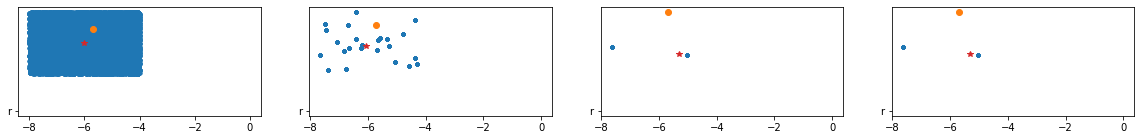

In [48]:
plt.figure(figsize=(20,2))

plt.subplot(1,4,1)
plt.plot(list_particles[0]['x'], list_particles[0]['y'],'.')
plt.plot(list_mesures[0][0]['x'], list_mesures[0][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[0][1]][0], list_predict[list_mesures[0][1]][1], '*')


plt.subplot(1,4,2)
plt.plot(list_particles[list_mesures[1][1]]['x'], list_particles[list_mesures[1][1]]['y'],'.')
plt.plot(list_mesures[1][0]['x'], list_mesures[1][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[1][1]][0], list_predict[list_mesures[1][1]][1], '*')


plt.subplot(1,4,3)
plt.plot(list_particles[list_mesures[2][1]]['x'], list_particles[list_mesures[2][1]]['y'],'.')
plt.plot(list_mesures[2][0]['x'], list_mesures[2][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[2][1]][0], list_predict[list_mesures[2][1]][1], '*')

plt.subplot(1,4,4)
plt.plot(list_particles[list_mesures[3][1]]['x'], list_particles[list_mesures[3][1]]['y'],'.')
plt.plot(list_mesures[3][0]['x'], list_mesures[3][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[3][1]][0], list_predict[list_mesures[3][1]][1], '*')

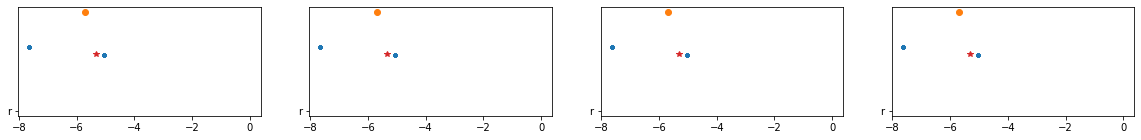

In [49]:
plt.figure(figsize=(20,2))

plt.subplot(1,4,1)
plt.plot(list_particles[list_mesures[5][1]]['x'], list_particles[list_mesures[5][1]]['y'],'.')
plt.plot(list_mesures[5][0]['x'], list_mesures[5][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[5][1]][0], list_predict[list_mesures[5][1]][1], '*')


plt.subplot(1,4,2)
plt.plot(list_particles[list_mesures[7][1]]['x'], list_particles[list_mesures[7][1]]['y'],'.')
plt.plot(list_mesures[7][0]['x'], list_mesures[7][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[7][1]][0], list_predict[list_mesures[7][1]][1], '*')


plt.subplot(1,4,3)
plt.plot(list_particles[list_mesures[10][1]]['x'], list_particles[list_mesures[10][1]]['y'],'.')
plt.plot(list_mesures[10][0]['x'], list_mesures[10][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[10][1]][0], list_predict[list_mesures[10][1]][1], '*')

plt.subplot(1,4,4)
plt.plot(list_particles[list_mesures[11][1]]['x'], list_particles[list_mesures[11][1]]['y'],'.')
plt.plot(list_mesures[11][0]['x'], list_mesures[11][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[11][1]][0], list_predict[list_mesures[11][1]][1], '*')

Text(0.5, 1.0, 'trajet réel')

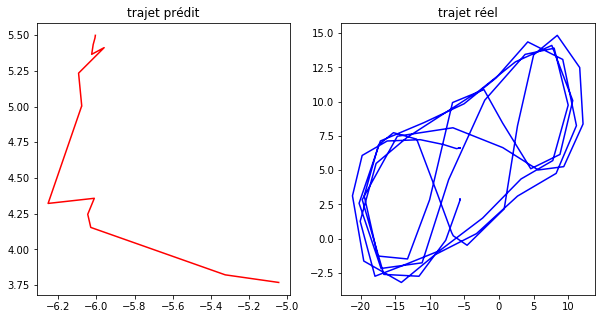

In [50]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.array(list_predict)[:,0], np.array(list_predict)[:,1], 'red')
plt.title('trajet prédit')

plt.subplot(1,2,2)
plt.plot(list_lati, list_longi, 'blue')
plt.title('trajet réel')
#xmin, xmax, ymin, ymax = plt.axis([-5.72,-5.68,-3, 15])

In [53]:
erreur = list()

for ite in range(10):
    _,_,_, list_erreur = particle_filter(N=10000, time=time_short)
    erreur.append(sum(list_erreur) / len(time_short))
    
print(f'erreur moyenne de {np.mean(erreur):06} ± {np.std(erreur):06}')

KeyboardInterrupt: 

# Algorithme Rao-Blackwell UKF

In [53]:
!pip3 install filterpy

     |████████████████████████████████| 184kB 936kB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110453 sha256=f5a4e6a50beeb21b9a25c9bd3a5985d0e44f52da457fcb60eef51c5d4b485e43
  Stored in directory: /Users/etiennelenaour/Library/Caches/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [54]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

In [98]:
def simple_resample_vectoriel(N, particles, gps_states, weights):
    
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, size = N))
    
    # Resample according to indexes
    particles = particles[indexes]
    gps_states = {key: gps_states[key][indexes] for key in gps_states}
    weights.fill(1.0 / N)
    
    return particles, gps_states, weights

def resample_v3_vectoriel(N, particles, gps_states, weights):
    index_particles_alive = np.random.choice(N, size=N, p=weights)
    gps_states = {key: gps_states[key][index_particles_alive] for key in gps_states}
    return particles[index_particles_alive], gps_states, np.ones(N) / N

In [69]:
def initilisation_pf_vectoriel(N):
    
    stretch = 1.02
    
    x_min, x_max = np.min(stretch * latitude), np.max(stretch * latitude)
    y_min, y_max = np.min(stretch * longtitude), np.max(stretch * longtitude)
    v_max = np.max(stretch * velocity)
    beta_min, beta_max = np.min(stretch * steering), np.max(stretch * steering)
    beta_dot = (steering[1:] - steering[:-1]) / (time_sensors[1:] - time_sensors[:-1])
    beta_dot_min, beta_dot_max = np.min(stretch * beta_dot), np.max(beta_dot)
    
    init_state = np.zeros((N, 6))
    # x
    init_state[:, 0] = np.random.uniform(low = x_min, high = x_max, size = N)
    # y
    init_state[:, 1] = np.random.uniform(low = y_min, high = y_max, size = N)
    # v
    init_state[:, 2] = np.random.uniform(low = 0, high = v_max, size = N)
    # psi
    init_state[:, 3] = np.random.uniform(low = 0, high = 2*np.pi, size = N)
    # beta
    init_state[:, 4] = np.random.uniform(low = beta_min, high = beta_max, size = N)
    # beta_point
    init_state[:, 5] = np.random.uniform(low = beta_dot_min, high = beta_dot_max, size = N)

    init_gps_state = {
        'sigma': np.exp(np.random.normal(0, 1, size = N)), # c'est un peu arbitraire, si vous avez mieux hesitez pas
        'alpha': np.ones((N, 2)) / (2 * N),
        'c': np.zeros(N), # tous les gps marchent bien a priori
    }
    
    init_uncertainty_matrices = [np.eye(6) for _ in range(N)]
    
#     init_gps_state = np.zeros((N, 3))
#     # sigma:
#     init_gps_state[:, 0] = np.exp(np.random.normal(0, 1, size = N)), # c'est un peu arbitraire, si vous avez mieux hesitez pas
#     # alpha:
#     init_gps_state[:, 1] = np.ones((N, 2)) / (2 * N),
#     # C:
#     init_gps_state[:, 2] = np.zeros(N), # tous les gps marchent bien a priori
    
    init_poids = np.ones(N) / N
    
    return init_state, init_gps_state, init_uncertainty_matrices, init_poids

In [70]:
def transition_model_vectoriel(current_state, dt):
    
    ''' return the state transition model WITHOUT taking into
    account the state noise (v' and beta'') '''
    
    # Retrieve initial states
    x = current_state[0]
    y = current_state[1]
    v = current_state[2]

    psi = current_state[3]
    beta = current_state[4]
    beta_dot = current_state[5]
    
    # Next states
    next_state = np.zeros(6)
    next_state[0] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state[1] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state[2] = v
    
    next_state[3] = psi + dt * v * np.tan(beta) / L
    next_state[4] = beta + dt * beta_dot
    next_state[5] = beta_dot

    return next_state

In [71]:
sigma_points = MerweScaledSigmaPoints(6, alpha=.1, beta=2., kappa=-1)

h1 = lambda state: [state[0], state[1]] # mesures de x et y
h23 = lambda state: [(1 + np.tan(state[2]) * H / L) * state[4], state[4]] # mesures de v et beta

var_gps = 0.2
var_sensors_mat = np.diag([0.1, 0.002])

def update_particles_ukf(N, dt, update_GPS, measures, particles, uncertainty_matrices, gps_states): 
    '''Met a jour l'etat des particules + matrices de cov des estimations
    avec un UKF'''
    new_particles = np.zeros((N, 6))
    new_uncertainty_matrices = list()
    if update_GPS:
        ukf_gps = UnscentedKalmanFilter(dim_x=6, dim_z=2, dt=dt, fx=transition_model_vectoriel, hx=h1, points=sigma_points)
        for i in range(N):
            ukf_gps.x = particles[i] # Etat estime de la particule
            ukf_gps.P = uncertainty_matrices[i] # matrice de covariance de l'estimation
            
            if gps_states['c'][i] == 0: # Fonctionnement nominal
                ukf_gps.R = var_gps * np.eye(2)
            else: # Mauvais fonctionnement, grosse incertitude 
                ukf_gps.R = 40 * var_gps * np.eye(2)
            
            ukf_gps.predict()
            ukf_gps.update(measures)
            new_particles[i] = ukf_gps.x
            new_uncertainty_matrices.append(ukf_gps.P)

    else:
        ukf_sensors = UnscentedKalmanFilter(dim_x=6, dim_z=2, dt=dt, fx=transition_model_vectoriel, hx=h23, points=sigma_points)
        ukf_sensors.R = var_sensors_mat
        for i in range(N):
            ukf_sensors.x = particles[i] # Etat estime de la particule
            ukf_sensors.P = uncertainty_matrices[i] # matrice de covariance de l'estimation
            
            # Etape predict et update
            ukf_sensors.predict()
            ukf_sensors.update(measures)
            
            new_particles[i] = ukf_sensors.x
            new_uncertainty_matrices.append(ukf_sensors.P)
    return new_particles, uncertainty_matrices

In [89]:
def update_model_vectoriel(N, weights, update_GPS, measures, particles, gps_state): 
    '''Met a jour les poids des particules'''
    # == Cas GPS
    if update_GPS:
        erreur_mesure = np.linalg.norm([particles[:, 0] - measures['x'],
                                        particles[:, 1] - measures['y']], axis = 0)
        c, c_proba = gps_state['c'], gps_state['c_proba']

        # mise à jour des poids
        weights *= c_proba * ((c == 0) * norm(0, var_gps).pdf(erreur_mesure) + (c == 1) * p0_z1(0))

    # == Cas sensors
    else:        
        # h3(x_t) = beta_t
        erreur_mesure_h3 = ((particles[:, 4] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        # h2(x_t) = (1 + tan(beta_t)) * v_t
        erreur_mesure_h2 = (1 + np.tan(particles[:, 4]) * H / L) * particles[:, 2] - (1 + np.tan(measures['beta']) * H / L) * measures['v']
        weights *= (
            norm(0, 0.1).pdf(erreur_mesure_h2)
            * norm(0, 0.002).pdf(erreur_mesure_h3)
        )
        
    
    weights += 1e-300 # Eviter les divisions par 0
    weights /= sum(weights) # normalize  
        
    return weights

In [99]:
def update_gps_states_new(N, gps_states, particles, measures):
    
    # Probabilite que c_{1, t} = 0:
    gps_states_new = dict()
    gps_states_new['c'], gps_states_new['c_proba'] = np.zeros(N), np.zeros(N)
    gps_states_new['alpha'], gps_states_new['alpha_proba'] = np.zeros((N, 2)), np.zeros(N)
    gps_states_new['sigma'], gps_states_new['sigma_proba'] = np.zeros(N), np.zeros(N)
    
    alpha = gps_states['alpha']
    sigma = gps_states['sigma']
    
    for i in range(N):
        
        ''' === ÉQUATION 29 page 11 ===
        Mise à jour de c '''
        
        z1 = [particles[i, 0], particles[i, 1]]
        h_x_1 = [measures['x'], measures['y']]
        
        p_c_0 = alpha[i][0] * p0_z1(z1) / (alpha[i][0] *  p0_z1(z1) 
                                           + alpha[i][1] * multivariate_normal.pdf(z1, h_x_1, S))

        sampled = np.random.binomial(1, p_c_0)

        gps_states_new['c'][i] = sampled
        gps_states_new['c_proba'][i] = p_c_0 if sampled == 0 else 1 - p_c_0
        

    for i in range(N):
        
        ''' === ÉQUATION 26 page 11 ===
        Mise à jour d'alpha '''
        
        params = sigma[i] * alpha[i] + (gps_states_new['c'][i] == 0)
        rv = beta(params[0], params[1])
        try:
            sampled = rv.rvs()
        except:
            print(params, sigma[i], alpha[i])
        proba = rv.pdf(sampled)
        
        gps_states_new['alpha'][i] = (sampled, 1 - sampled)
        gps_states_new['alpha_proba'][i] = proba
        
    rv = scipy.stats.norm(0, 1)
    
    for i in range(N):
        
        ''' === ÉQUATION 28 page 11 ===
        Mise à jour de sigma '''
        # !!!! ATTENTION C'EST PAS LA BONNE FORMULE !!!!
        # !!!! TODO: FIX !!!!
        
        sampled = rv.rvs()
        gps_states_new['sigma'][i] = gps_states['sigma'][i] * np.exp(sampled)
        gps_states_new['sigma_proba'][i] = rv.pdf(sampled)

    return gps_states_new

In [100]:
def predictions_vectoriel(weights, particles):
    
    tab_predict = [sum(particles[:, 0] * weights), sum(particles[:, 1] * weights), 
                   sum(particles[:, 2] * weights), sum(particles[:, 4] * weights)]
    
    return tab_predict

In [101]:
@timing
def rao_blackwell_filter(N = 10000, skip = 1, verbose = 10, tmax=200):
    
    #liste à remplir
    list_predict = list()
    list_particles = list()
    list_mesures = list()
    list_erreur = list()
    
    # === Initialisation === #
    particles, gps_states, uncertainty_matrices, weights = initilisation_pf_vectoriel(N)
    t_previous = time[0] / 1000.

    # === Itérations === #
    for i in range(min(len(time), tmax)):
        
        if i % verbose == 0:
            print('iteration :', i)
            
        if i % skip == 0:
            t = time[i] / 1000.
            update_GPS = (sensor[i] == 1)

            # Si on reçoit une mesure du GPS
            if update_GPS:
                measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
                measures_vect = [latitude[index[i]], longtitude[index[i]]]
                list_mesures.append([measures,i])

                # Update de c, alpha et sigma :
                gps_states = update_gps_states_new(N, gps_states, particles, measures)
                
                # Update de x chapeau et SIGMA avec UKF :
                particles, uncertainty_matrices = update_particles_ukf(N, t-t_previous, update_GPS, measures_vect,
                                                                       particles, uncertainty_matrices, gps_states)


            # Si on reçoit une mesure du sensor
            else:
                measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}
                measures_vect = [steering[index[i]], velocity[index[i]]]
                
                # Update de x chapeau et SIGMA avec UKF :
                particles, uncertainty_matrices = update_particles_ukf(N, t-t_previous, update_GPS, measures_vect,
                                                                       particles, uncertainty_matrices, gps_states)

            # Update des poids :
            weights = update_model_vectoriel(N, weights, update_GPS, measures, particles, gps_states)

            # Resampling :
            Neff = 1. / sum(weights ** 2)
            if (Neff <= 0.8 * N) :
                print('Resampled')
                particles, gps_states, weights = resample_v3_vectoriel(N, particles, gps_states, weights)

            t_previous = t
            list_predict.append(predictions_vectoriel(weights, particles))
            
            if update_GPS:
                list_erreur.append(abs(predictions_vectoriel(weights, particles)[0] - latitude[index[i]]) + 
                              abs(predictions_vectoriel(weights, particles)[1] - longtitude[index[i]]))
            
            list_particles.append(particles)
            
    return list_predict, list_particles, list_mesures, list_erreur 

# Application du rao_blackwell_filter

Pour 100 unités de temps nous avons : 1040 mesures GPS


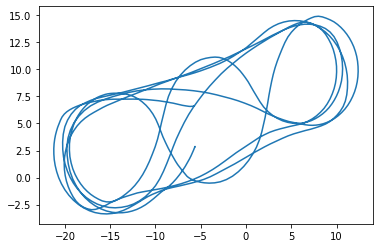

In [103]:
time_short = time[:]
list_longi = list()
list_lati = list()

for i in range(len(time_short)):

        update_GPS = sensor[i] == 1
        if update_GPS:
            list_lati.append(latitude[index[i]])
            list_longi.append(longtitude[index[i]])

print('Pour 100 unités de temps nous avons :', len(list_lati), 'mesures GPS')            
plt.plot(list_lati, list_longi)

#### We want to follow this trajectory

In [104]:
list_predict, list_particles, list_mesures, list_erreur = rao_blackwell_filter(N = 1000, skip = 1, verbose = 10, tmax = len(time_short))

iteration : 0
Resampled
Resampled
iteration : 10
Resampled
iteration : 20
Resampled
iteration : 30
Resampled
iteration : 40
Resampled
iteration : 50
Resampled
iteration : 60
Resampled
iteration : 70
Resampled
Resampled
iteration : 80
Resampled
iteration : 90
Resampled
iteration : 100
Resampled
iteration : 110
Resampled
iteration : 120
Resampled
iteration : 130
Resampled
iteration : 140
Resampled
iteration : 150
Resampled
iteration : 160
Resampled
Resampled
iteration : 170
Resampled
iteration : 180
Resampled
iteration : 190
Resampled
iteration : 200
Resampled
iteration : 210
Resampled
iteration : 220
Resampled
iteration : 230
Resampled
iteration : 240
Resampled
iteration : 250
Resampled
Resampled
iteration : 260
Resampled
iteration : 270
Resampled
iteration : 280
Resampled
iteration : 290
Resampled
iteration : 300
Resampled
iteration : 310
Resampled
iteration : 320
Resampled
iteration : 330
Resampled
iteration : 340
Resampled
Resampled
iteration : 350
Resampled
iteration : 360
Resampled

Resampled
iteration : 2960
Resampled
iteration : 2970
Resampled
iteration : 2980
Resampled
Resampled
iteration : 2990
Resampled
iteration : 3000
Resampled
iteration : 3010
Resampled
iteration : 3020
Resampled
iteration : 3030
Resampled
iteration : 3040
Resampled
iteration : 3050
Resampled
iteration : 3060
Resampled
iteration : 3070
Resampled
Resampled
iteration : 3080
Resampled
iteration : 3090
Resampled
iteration : 3100
Resampled
iteration : 3110
Resampled
iteration : 3120
Resampled
iteration : 3130
Resampled
iteration : 3140
Resampled
iteration : 3150
Resampled
iteration : 3160
Resampled
Resampled
iteration : 3170
Resampled
iteration : 3180
Resampled
iteration : 3190
Resampled
iteration : 3200
Resampled
iteration : 3210
Resampled
iteration : 3220
Resampled
iteration : 3230
Resampled
iteration : 3240
Resampled
iteration : 3250
Resampled
Resampled
iteration : 3260
Resampled
iteration : 3270
Resampled
iteration : 3280
Resampled
iteration : 3290
Resampled
iteration : 3300
Resampled
itera

Resampled
iteration : 5880
Resampled
Resampled
iteration : 5890
Resampled
iteration : 5900
Resampled
iteration : 5910
Resampled
iteration : 5920
Resampled
iteration : 5930
Resampled
iteration : 5940
Resampled
iteration : 5950
Resampled
iteration : 5960
Resampled
iteration : 5970
Resampled
Resampled
iteration : 5980
Resampled
iteration : 5990
Resampled
iteration : 6000
Resampled
iteration : 6010
Resampled
iteration : 6020
Resampled
iteration : 6030
Resampled
iteration : 6040
Resampled
iteration : 6050
Resampled
iteration : 6060
Resampled
iteration : 6070
Resampled
Resampled
iteration : 6080
Resampled
iteration : 6090
Resampled
iteration : 6100
Resampled
iteration : 6110
Resampled
iteration : 6120
Resampled
iteration : 6130
Resampled
iteration : 6140
Resampled
iteration : 6150
Resampled
iteration : 6160
Resampled
Resampled
iteration : 6170
Resampled
iteration : 6180
Resampled
iteration : 6190
Resampled
iteration : 6200
Resampled
iteration : 6210
Resampled
iteration : 6220
Resampled
itera

Resampled
Resampled
iteration : 8800
Resampled
iteration : 8810
Resampled
iteration : 8820
Resampled
iteration : 8830
Resampled
iteration : 8840
Resampled
iteration : 8850
Resampled
iteration : 8860
Resampled
iteration : 8870
Resampled
iteration : 8880
Resampled
Resampled
iteration : 8890
Resampled
iteration : 8900
Resampled
iteration : 8910
Resampled
iteration : 8920
Resampled
iteration : 8930
Resampled
iteration : 8940
Resampled
iteration : 8950
Resampled
iteration : 8960
Resampled
iteration : 8970
Resampled
Resampled
iteration : 8980
Resampled
iteration : 8990
Resampled
iteration : 9000
Resampled
iteration : 9010
Resampled
iteration : 9020
Resampled
iteration : 9030
Resampled
iteration : 9040
Resampled
iteration : 9050
Resampled
iteration : 9060
Resampled
Resampled
iteration : 9070
Resampled
iteration : 9080
Resampled
iteration : 9090
Resampled
iteration : 9100
Resampled
iteration : 9110
Resampled
iteration : 9120
Resampled
iteration : 9130
Resampled
iteration : 9140
Resampled
itera

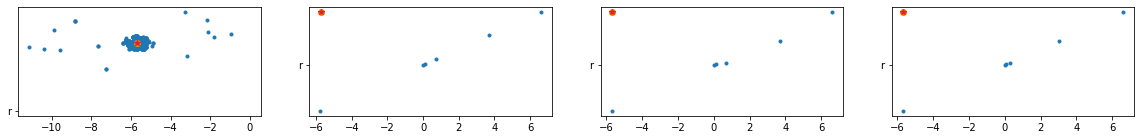

In [105]:
plt.figure(figsize=(20,2))

plt.subplot(1,4,1)
plt.plot(list_particles[0][:,0], list_particles[0][:,1],'.')
plt.plot(list_mesures[0][0]['x'], list_mesures[0][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[0][1]][0], list_predict[list_mesures[0][1]][1], '*')


plt.subplot(1,4,2)
plt.plot(list_particles[list_mesures[1][1]][0], list_particles[list_mesures[1][1]][1],'.')
plt.plot(list_mesures[1][0]['x'], list_mesures[1][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[1][1]][0], list_predict[list_mesures[1][1]][1], '*')


plt.subplot(1,4,3)
plt.plot(list_particles[list_mesures[2][1]][0], list_particles[list_mesures[2][1]][1],'.')
plt.plot(list_mesures[2][0]['x'], list_mesures[2][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[2][1]][0], list_predict[list_mesures[2][1]][1], '*')

plt.subplot(1,4,4)
plt.plot(list_particles[list_mesures[3][1]][0], list_particles[list_mesures[3][1]][1],'.')
plt.plot(list_mesures[3][0]['x'], list_mesures[3][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[3][1]][0], list_predict[list_mesures[3][1]][1], '*')

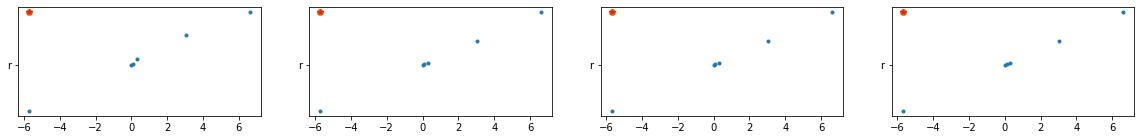

In [106]:
plt.figure(figsize=(20,2))

plt.subplot(1,4,1)
plt.plot(list_particles[list_mesures[5][1]][0], list_particles[list_mesures[5][1]][1],'.')
plt.plot(list_mesures[5][0]['x'], list_mesures[5][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[5][1]][0], list_predict[list_mesures[5][1]][1], '*')


plt.subplot(1,4,2)
plt.plot(list_particles[list_mesures[7][1]][0], list_particles[list_mesures[7][1]][1],'.')
plt.plot(list_mesures[7][0]['x'], list_mesures[7][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[7][1]][0], list_predict[list_mesures[7][1]][1], '*')


plt.subplot(1,4,3)
plt.plot(list_particles[list_mesures[9][1]][0], list_particles[list_mesures[9][1]][1],'.')
plt.plot(list_mesures[9][0]['x'], list_mesures[9][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[9][1]][0], list_predict[list_mesures[9][1]][1], '*')

plt.subplot(1,4,4)
plt.plot(list_particles[list_mesures[11][1]][0], list_particles[list_mesures[11][1]][1],'.')
plt.plot(list_mesures[11][0]['x'], list_mesures[11][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[11][1]][0], list_predict[list_mesures[11][1]][1], '*')

#### Plot du trajet prédit et du vrai trajet

Text(0.5, 1.0, 'trajet réel')

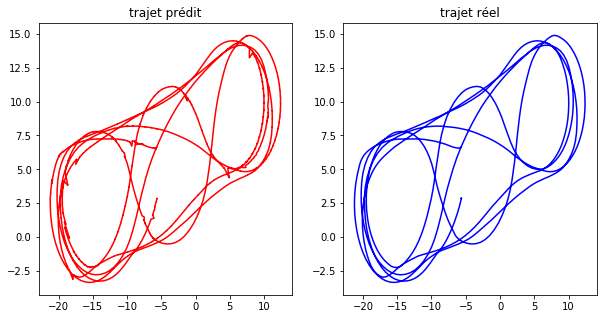

In [107]:
#Plot result
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.array(list_predict)[:,0], np.array(list_predict)[:,1], 'red')
plt.title('trajet prédit')

plt.subplot(1,2,2)
plt.plot(list_lati, list_longi, 'blue')
plt.title('trajet réel')

In [55]:
erreur = list()

for ite in range(10):
    _,_,_, list_erreur = rao_blackwell_filter(N = 10000, skip = 1, verbose = 10, tmax=100)
    erreur.append(sum(list_erreur) / len(time_short))
    
print('erreur moyenne de ', np.mean(erreur),' + ou - ', np.std(erreur))

iteration : 0
Resampled
Resampled
[0.49167581 0.        ] 0.4916758095059584 [1. 0.]
[2.50745307 0.        ] 2.5074530738626444 [1. 0.]
[1.26957743 0.        ] 1.2695774349118831 [1. 0.]
[2.671165 0.      ] 2.671165004389526 [1. 0.]
[0.08080188 0.        ] 0.08080188465326847 [1. 0.]
[5.83818607 0.        ] 5.838186066673381 [1. 0.]
[0.26859649 0.        ] 0.2685964926355733 [1. 0.]
[0.49167581 0.        ] 0.4916758095059584 [1. 0.]
[1.74439572 0.        ] 1.74439571944566 [1. 0.]
[0.65166799 0.        ] 0.6516679871492578 [1. 0.]
[2.60565732 0.        ] 2.605657317994028 [1. 0.]
[0.67090239 0.        ] 0.670902385930422 [1. 0.]
[9.28748224 0.        ] 9.287482238650869 [1. 0.]
[1.00570671 0.        ] 1.0057067061686287 [1. 0.]
[2.39832068 0.        ] 2.398320677320393 [1. 0.]
[5.83818607 0.        ] 5.838186066673381 [1. 0.]
[0.89194206 0.        ] 0.8919420631708801 [1. 0.]
[5.83818607 0.        ] 5.838186066673381 [1. 0.]
[7.75250782 0.        ] 7.752507815609332 [1. 0.]
[0.65166799

Resampled
iteration : 60
Resampled
iteration : 70
Resampled
Resampled
iteration : 80
Resampled
iteration : 90
Resampled
iteration : 0
Resampled
Resampled
[0.3658064 0.       ] 0.365806401989214 [1. 0.]
[0.58601472 0.        ] 0.5860147152679812 [1. 0.]
[0.71050027 0.        ] 0.7105002723390685 [1. 0.]
[1.01508349 0.        ] 1.0150834927188008 [1. 0.]
[0.16499924 0.        ] 0.16499923784840997 [1. 0.]
[0.71050027 0.        ] 0.7105002723390685 [1. 0.]
[0.3785287 0.       ] 0.3785286996648728 [1. 0.]
[3.07390966 0.        ] 3.073909661883856 [1. 0.]
[0.16499924 0.        ] 0.16499923784840997 [1. 0.]
[5.18129453 0.        ] 5.181294531725038 [1. 0.]
[0.79129585 0.        ] 0.7912958459723322 [1. 0.]
[0.64504456 0.        ] 0.6450445625052652 [1. 0.]
[1.50606552 0.        ] 1.5060655228676207 [1. 0.]
[0.71050027 0.        ] 0.7105002723390685 [1. 0.]
[5.18129453 0.        ] 5.181294531725038 [1. 0.]
[1.50606552 0.        ] 1.5060655228676207 [1. 0.]
[1.19430531 0.        ] 1.1943053123

[1.8926201 0.       ] 1.892620100242258 [1. 0.]
[0.77222629 0.        ] 0.7722262880247514 [1. 0.]
[2.61131201 0.        ] 2.6113120060105373 [1. 0.]
[0.90920541 0.        ] 0.9092054064770204 [1. 0.]
[0.77222629 0.        ] 0.7722262880247514 [1. 0.]
[1.8926201 0.       ] 1.892620100242258 [1. 0.]
[1.19681035 0.        ] 1.1968103457548813 [1. 0.]
[0.20871357 0.        ] 0.20871357036171975 [1. 0.]
[0.77222629 0.        ] 0.7722262880247514 [1. 0.]
[2.17736504 0.        ] 2.1773650434546283 [1. 0.]
[2.05381719 0.        ] 2.0538171878433036 [1. 0.]
[1.19681035 0.        ] 1.1968103457548813 [1. 0.]
[0.1690901 0.       ] 0.16909009966609875 [1. 0.]
[3.64789201 0.        ] 3.647892010070515 [1. 0.]
[6.42494162 0.        ] 6.424941621505778 [1. 0.]
[0.1690901 0.       ] 0.16909009966609875 [1. 0.]
[0.15605538 0.        ] 0.1560553837635652 [1. 0.]
[2.72784204 0.        ] 2.7278420449791874 [1. 0.]
[0.15605538 0.        ] 0.1560553837635652 [1. 0.]
[0.1690901 0.       ] 0.1690900996660987

KeyboardInterrupt: 

In [56]:
print('erreur moyenne de ', np.mean(erreur),' + ou - ', np.std(erreur))

erreur moyenne de  0.00025549584563197667  + ou -  0.00011959735391518241


In [57]:
erreur

[0.0002309099414039295,
 0.00020871805083366723,
 0.00013012632024914873,
 0.0004522290700411613]